# &#x1F4D1; &nbsp;  $\mathfrak {\color{#191970} {P5: \ Build \ a \ Digit \ Recognition \ Program. \ Step \ 2}}$

---
## $\mathfrak {\color{##191970} {Code \ Library \ and \ Links}}$
Multi-dimensional image processing https://docs.scipy.org/doc/scipy/reference/ndimage.html

Keras: Deep Learning library for Theano and TensorFlow https://keras.io/
 
Deep MNIST for Experts https://www.tensorflow.org/get_started/mnist/pros

Tensorflow Deep MNIST Advanced Tutorial http://docs.seldon.io/tensorflow-deep-mnist-example.html

Handwritten Digit Recognition using Convolutional Neural Networks in Python with Keras

http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/

In [3]:
from IPython.core.display import HTML
hide_code = ''
HTML('''
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    }
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #191970; background: ghostwhite; opacity: 0.9; " \
type="submit" value="Click to display or hide code">
</form>
''')

In [4]:
hide_code
import numpy as np
import pandas as pd
import scipy as sp
import scipy.ndimage
import random
import scipy.misc
from scipy.special import expit
from time import time

import os
import sys
import h5py
import tarfile

from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

from IPython.display import display, Image, IFrame
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib import offsetbox

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [5]:
hide_code
from sklearn.neural_network import MLPClassifier, BernoulliRBM
from sklearn import linear_model, datasets, metrics
from sklearn.pipeline import Pipeline
from sklearn import manifold, decomposition, ensemble
from sklearn import discriminant_analysis, random_projection
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.examples.tutorials.mnist as mnist

import keras as ks
from keras.models import Sequential, load_model
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.models import Model

Using TensorFlow backend.


In [6]:
hide_code
def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
      
        last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception('Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

def maybe_extract(file_, force=False):
    filename = os.path.splitext(os.path.splitext(file_)[0])[0]  # remove .tar.gz
    
    if os.path.isdir(filename) and not force:
        # You may override by setting force=True.
        print('%s is already presented - Skipping extraction of %s.' % (filename, file_))
    else:
        print('Extracting %s file data. Please wait...' % file_)
        tar = tarfile.open(file_)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
        print('File %s is successfully extracted into %s directory.' % (file_, filename))        
    
    return filename

In [7]:
hide_code
# https://github.com/sarahrn/Py-Gsvhn-DigitStruct-Reader/blob/master/digitStruct.py
#################
# Bounding Box #
################
class BBox:
    def __init__(self):
        self.label = ""     # Digit
        self.left = 0
        self.top = 0
        self.width = 0
        self.height = 0

class DigitStruct:
    def __init__(self):
        self.name = None    # Image file name
        self.bboxList = None # List of BBox structs

# Function for debugging
def printHDFObj(theObj, theObjName):
    isFile = isinstance(theObj, h5py.File)
    isGroup = isinstance(theObj, h5py.Group)
    isDataSet = isinstance(theObj, h5py.Dataset)
    isReference = isinstance(theObj, h5py.Reference)
    print ("{}".format(theObjName))
    print ("    type(): {}".format(type(theObj)))
    if isFile or isGroup or isDataSet:
        # if theObj.name != None:
        #    print "    name: {}".format(theObj.name)
        print ("    id: {}".format(theObj.id))
    if isFile or isGroup:
        print ("    keys: {}".format(theObj.keys()))
    if not isReference:
        print ("    Len: {}".format(len(theObj)))

    if not (isFile or isGroup or isDataSet or isReference):
        print (theObj)

def readDigitStructGroup(dsFile):
    dsGroup = dsFile["digitStruct"]
    return dsGroup

#####################################################
# Reads a string from the file using its reference #
####################################################
def readString(strRef, dsFile):
    strObj = dsFile[strRef]
    str = ''.join(chr(i) for i in strObj)
    return str
#########################################
# Reads an integer value from the file #
########################################
def readInt(intArray, dsFile):
    intRef = intArray[0]
    isReference = isinstance(intRef, h5py.Reference)
    intVal = 0
    if isReference:
        intObj = dsFile[intRef]
        intVal = int(intObj[0])
    else: # Assuming value type
        intVal = int(intRef)
    return intVal

def yieldNextInt(intDataset, dsFile):
    for intData in intDataset:
        intVal = readInt(intData, dsFile)
        yield intVal 

def yieldNextBBox(bboxDataset, dsFile):
    for bboxArray in bboxDataset:
        bboxGroupRef = bboxArray[0]
        bboxGroup = dsFile[bboxGroupRef]
        labelDataset = bboxGroup["label"]
        leftDataset = bboxGroup["left"]
        topDataset = bboxGroup["top"]
        widthDataset = bboxGroup["width"]
        heightDataset = bboxGroup["height"]

        left = yieldNextInt(leftDataset, dsFile)
        top = yieldNextInt(topDataset, dsFile)
        width = yieldNextInt(widthDataset, dsFile)
        height = yieldNextInt(heightDataset, dsFile)

        bboxList = []

        for label in yieldNextInt(labelDataset, dsFile):
            bbox = BBox()
            bbox.label = label
            bbox.left = next(left)
            bbox.top = next(top)
            bbox.width = next(width)
            bbox.height = next(height)
            bboxList.append(bbox)

        yield bboxList

def yieldNextFileName(nameDataset, dsFile):
    for nameArray in nameDataset:
        nameRef = nameArray[0]
        name = readString(nameRef, dsFile)
        yield name

def yieldNextDigitStruct(dsFileName):
    dsFile = h5py.File(dsFileName, 'r')
    dsGroup = readDigitStructGroup(dsFile)
    nameDataset = dsGroup["name"]
    bboxDataset = dsGroup["bbox"]

    bboxListIter = yieldNextBBox(bboxDataset, dsFile)
    for name in yieldNextFileName(nameDataset, dsFile):
        bboxList = next(bboxListIter)
        obj = DigitStruct()
        obj.name = name
        obj.bboxList = bboxList
        yield obj
        
def testMain():

    dsFileName = 'train/digitStruct.mat'
    testCounter = 0
    for dsObj in yieldNextDigitStruct(dsFileName):
        # testCounter += 1
        print (dsObj.name)
        for bbox in dsObj.bboxList:
            print ("    {}:{},{},{},{}".format(bbox.label, bbox.left, bbox.top, bbox.width, bbox.height))
        if testCounter >= 5:
            break

# if __name__ == "__main__":
#     testMain()

In [8]:
hide_code
def testMain():

    dsFileName = 'test/digitStruct.mat'
    testCounter = 0
    for dsObj in yieldNextDigitStruct(dsFileName):
        # testCounter += 1
        print (dsObj.name)
        for bbox in dsObj.bboxList:
            print ("    {}:{},{},{},{}".format(bbox.label, bbox.left, bbox.top, bbox.width, bbox.height))
        if testCounter >= 5:
            break

# if __name__ == "__main__":
#     testMain()

In [9]:
hide_code
def testMain():

    dsFileName = 'extra/digitStruct.mat'
    testCounter = 0
    for dsObj in yieldNextDigitStruct(dsFileName):
        # testCounter += 1
        print (dsObj.name)
        for bbox in dsObj.bboxList:
            print ("    {}:{},{},{},{}".format(bbox.label, bbox.left, bbox.top, bbox.width, bbox.height))
        if testCounter >= 5:
            break

# if __name__ == "__main__":
#     testMain()

In [10]:
hide_code
# https://github.com/sarahrn/Py-Gsvhn-DigitStruct-Reader/blob/master/digitStructMatToCsv.py
def writeToCsvFile(dsFileName, csvFile):
    fileCount = 0
    csvFile.write("FileName,DigitLabel,Left,Top,Width,Height\n")
    for dsObj in yieldNextDigitStruct(dsFileName):
        fileCount += 1
        for bbox in dsObj.bboxList:
            csvLine = "{},{},{},{},{},{}\n".format(
                dsObj.name,
                bbox.label, bbox.left, bbox.top, bbox.width, bbox.height)
            csvFile.write(csvLine)
    print("Number of image files: {}".format(fileCount))

def convertToCsv(dsFilePath, csvFilePath):
    with open(csvFilePath, "w") as csvFile:
        writeToCsvFile(dsFilePath, csvFile)

def main():
    dsFilePath = 'train/digitStruct.mat'
    csvFilePath = 'train_digitStruct.csv'
    print("Converting {0} to {1}".format(dsFilePath, csvFilePath))
    convertToCsv(dsFilePath, csvFilePath)

# if __name__ == "__main__":
#     main()

In [11]:
hide_code
def main():
    dsFilePath = 'test/digitStruct.mat'
    csvFilePath = 'test_digitStruct.csv'
    print("Converting {0} to {1}".format(dsFilePath, csvFilePath))
    convertToCsv(dsFilePath, csvFilePath)

# if __name__ == "__main__":
#     main()

In [12]:
hide_code
def main():
    dsFilePath = 'extra/digitStruct.mat'
    csvFilePath = 'extra_digitStruct.csv'
    print("Converting {0} to {1}".format(dsFilePath, csvFilePath))
    convertToCsv(dsFilePath, csvFilePath)

# if __name__ == "__main__":
#     main()

In [13]:
hide_code
def grouped_by_filename(data):    
    filename_set = np.array(list(set(data['filename'])))
    n = filename_set.shape[0]
    labels = []
    boxes = []
    data_gr = data.groupby(['filename'])
    for i in range(n):
        x = filename_set[i]
        labels.append(np.array(data_gr.get_group(x)['label']))
        boxes.append(np.array(data_gr.get_group(x)['box']))
    labels = np.array(labels)
    boxes = np.array(boxes)
    data_g = {'filename': filename_set, 'label': labels, 'box': boxes}
    new_data = pd.DataFrame(data=data_g)
    return new_data

In [14]:
hide_code
def fivedigit_label(label):
    size = len(label)
    if size >= 5:
        return label
    else:
        num_zeros = np.full((5-size), 10)
        return np.array(np.concatenate((num_zeros, label), axis = 0))
    
def get_labels(data):
    string = data.replace('[', '').replace(']', '').replace(',', '')
    labels = np.array([int(n) for n in string.split()])
    return labels

def image_box(box):
        left, top, width, height = box[:, 0], box[:, 1], box[:, 2], box[:, 3]
        
        image_left = min(left) + 1
        image_top = min(top) + 1
        image_bottom = max(top) + max(height)
        image_right = max(left) + max(width)
        return np.array([image_left, image_right, image_top, image_bottom])

def get_box(data):
    value = data.values[0]
    string = value.replace('[', '').replace(']', '').replace(',', '')
    numbers = np.array([int(n) for n in string.split()])        
    k = len(numbers)/4
    numbers = numbers.reshape(k, 4)       
    return numbers

def get_image(folder, image_file):
    filename=os.path.join(folder, image_file)
    image = scipy.ndimage.imread(filename, mode='RGB')
    
    if folder == 'train':
        n = np.where(train_filenames == image_file)[0]
        box = np.array(get_box(train_b['box'][n]))
        label = train_labels[n]
        
    elif folder == 'test':
        n = np.where(test_filenames == image_file)[0]
        box = np.array(get_box(test_b['box'][n]))
        label = test_labels[n]
        
    elif folder == 'extra':
        n = np.where(extra_filenames == image_file)[0]
        box = np.array(get_box(extra_b['box'][n]))
        label = extra_labels[n]
        
    nbox = image_box(box)
    image_left, image_right, image_top, image_bottom = nbox[0], nbox[1], nbox[2], nbox[3]
    
    image_bottom = min(image.shape[0], image_bottom)
    image_right = min(image.shape[1], image_right)
                   
    nimage = image[image_top:image_bottom, image_left:image_right]
    
    image32_1 = scipy.misc.imresize(nimage, (32, 32, 3)) / 255
    image32_2 = np.dot(np.array(image64_1, dtype='float32'), [0.299, 0.587, 0.114])
    return image32_1, image32_2, label

---
## $\mathfrak {\color{#191970} {Experimental \ Datasets}}$

#### Dataset #5. Stanford.edu. Housenumbers

http://ufldl.stanford.edu/housenumbers/

In [15]:
hide_code
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

train_filename = maybe_download('train.tar.gz', 404141560)
test_filename = maybe_download('test.tar.gz', 276555967)
extra_filename = maybe_download('extra.tar.gz', 1955489752)

Found and verified ./train.tar.gz
Found and verified ./test.tar.gz
Found and verified ./extra.tar.gz


In [16]:
hide_code
train_folder = maybe_extract(train_filename)
test_folder = maybe_extract(test_filename)
extra_folder = maybe_extract(extra_filename)

./train is already presented - Skipping extraction of ./train.tar.gz.
./test is already presented - Skipping extraction of ./test.tar.gz.
./extra is already presented - Skipping extraction of ./extra.tar.gz.


A few examples of images


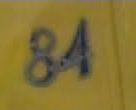

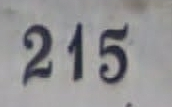

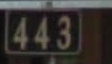

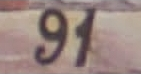

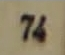

In [18]:
hide_code
print('A few examples of images')
image_path = os.path.join('extra')
images = [f for f in os.listdir(image_path) if f.endswith('.png')][1010:1015]
for image in images:
    display(Image(filename=os.path.join(image_path,image)))

In [21]:
hide_code
train_set = pd.read_csv("train_digitStruct.csv")
test_set = pd.read_csv("test_digitStruct.csv")
extra_set = pd.read_csv("extra_digitStruct.csv")
display(train_set.head(3))
display(test_set.head(3))
display(extra_set.head(3))

,FileName,DigitLabel,Left,Top,Width,Height
0,1.png,1,246,77,81,219
1,1.png,9,323,81,96,219
2,2.png,2,77,29,23,32


,FileName,DigitLabel,Left,Top,Width,Height
0,1.png,5,43,7,19,30
1,2.png,2,99,5,14,23
2,2.png,1,114,8,8,23


,FileName,DigitLabel,Left,Top,Width,Height
0,1.png,4,24,70,38,56
1,1.png,7,55,41,36,56
2,1.png,8,79,23,47,56


In [19]:
hide_code
train_box = [[train_set['Left'][i], train_set['Top'][i], 
              train_set['Width'][i], train_set['Height'][i]] 
             for i in range(len(train_set))]

test_box = [[test_set['Left'][i], test_set['Top'][i], 
             test_set['Width'][i], test_set['Height'][i]] 
            for i in range(len(test_set))]

extra_box = [[extra_set['Left'][i], extra_set['Top'][i], 
              extra_set['Width'][i], extra_set['Height'][i]] 
             for i in range(len(extra_set))]

In [23]:
hide_code
train_d = {'filename': train_set['FileName'], 'label': train_set['DigitLabel'], 'box': train_box}
train_df = pd.DataFrame(data=train_d)

test_d = {'filename': test_set['FileName'], 'label': test_set['DigitLabel'], 'box': test_box}
test_df = pd.DataFrame(data=test_d)

extra_d = {'filename': extra_set['FileName'], 'label': extra_set['DigitLabel'], 'box': extra_box}
extra_df = pd.DataFrame(data=extra_d)

display(train_df.head(3))
display(test_df.head(3))
display(extra_df.head(3))

,box,filename,label
0,"[246, 77, 81, 219]",1.png,1
1,"[323, 81, 96, 219]",1.png,9
2,"[77, 29, 23, 32]",2.png,2


,box,filename,label
0,"[43, 7, 19, 30]",1.png,5
1,"[99, 5, 14, 23]",2.png,2
2,"[114, 8, 8, 23]",2.png,1


,box,filename,label
0,"[24, 70, 38, 56]",1.png,4
1,"[55, 41, 36, 56]",1.png,7
2,"[79, 23, 47, 56]",1.png,8


***Group by file name***

In [23]:
hide_code
# train_g = grouped_by_filename(train_df)
# test_g = grouped_by_filename(test_df)
# extra_g = grouped_by_filename(extra_df)

''

In [543]:
hide_code
# train_g.to_csv('train_group.csv', index=False)
# test_g.to_csv('test_group.csv', index=False)
# extra_g.to_csv('extra_group.csv', index=False)
display(train_g.head(3))
display(test_g.head(3))
display(extra_g.head(3))

,box,filename,label
0,"[[33, 10, 12, 24], [45, 10, 11, 24]]",5502.png,"[3, 5]"
1,"[[35, 7, 11, 37], [44, 3, 11, 37]]",6876.png,"[1, 5]"
2,"[[99, 32, 35, 51], [125, 29, 31, 51]]",12741.png,"[2, 9]"


,box,filename,label
0,"[[35, 10, 15, 22], [51, 9, 12, 22], [63, 10, 1...",5502.png,"[1, 7, 1]"
1,"[[135, 40, 10, 22], [146, 38, 16, 22]]",1166.png,"[1, 7]"
2,"[[125, 37, 17, 25], [141, 41, 16, 25]]",506.png,"[2, 8]"


,box,filename,label
0,"[[21, 16, 34, 56], [55, 6, 26, 56], [80, 1, 42...",1380.png,"[5, 10, 10]"
1,"[[5, 4, 11, 22], [15, 2, 14, 22]]",1781.png,"[5, 3]"
2,"[[9, 16, 24, 48], [36, 17, 25, 48], [63, 14, 2...",1166.png,"[4, 9, 10]"


In [19]:
hide_code
train_b = pd.read_csv("train_group.csv")
test_b = pd.read_csv("test_group.csv")
extra_b = pd.read_csv("extra_group.csv")

display(train_b.head(3))
display(test_b.head(3))
display(extra_b.head(3))

,box,filename,label
0,"[[33, 10, 12, 24] [45, 10, 11, 24]]",5502.png,[3 5]
1,"[[35, 7, 11, 37] [44, 3, 11, 37]]",6876.png,[1 5]
2,"[[99, 32, 35, 51] [125, 29, 31, 51]]",12741.png,[2 9]


,box,filename,label
0,"[[35, 10, 15, 22] [51, 9, 12, 22] [63, 10, 12,...",5502.png,[1 7 1]
1,"[[135, 40, 10, 22] [146, 38, 16, 22]]",1166.png,[1 7]
2,"[[125, 37, 17, 25] [141, 41, 16, 25]]",506.png,[2 8]


,box,filename,label
0,"[[21, 16, 34, 56] [55, 6, 26, 56] [80, 1, 42, ...",1380.png,[ 5 10 10]
1,"[[5, 4, 11, 22] [15, 2, 14, 22]]",1781.png,[5 3]
2,"[[9, 16, 24, 48] [36, 17, 25, 48] [63, 14, 29,...",1166.png,[ 4 9 10]


***Check labels***

In [20]:
hide_code
train_labels = np.array([get_labels(train_b['label'][i]) for i in range(len(train_b))])
train_filenames = train_b['filename']

test_labels = np.array([get_labels(test_b['label'][i]) for i in range(len(test_b))])
test_filenames = test_b['filename']

extra_labels = np.array([get_labels(extra_b['label'][i]) for i in range(len(extra_b))])
extra_filenames = extra_b['filename']

In [21]:
hide_code
np.where([len(train_labels[i])>5 for i in range(len(train_b))])[0]

array([29190])

In [22]:
hide_code
np.where([len(test_labels[i])>5 for i in range(len(test_b))])[0]

array([], dtype=int64)

In [23]:
hide_code
np.where([len(extra_labels[i])>5 for i in range(len(extra_b))])[0]

array([], dtype=int64)

In [24]:
hide_code
sum(np.array([len(train_labels[i])==0 for i in range(len(train_b))]))

0

In [25]:
hide_code
sum(np.array([len(test_labels[i])==0 for i in range(len(test_b))]))

0

In [26]:
hide_code
sum(np.array([len(extra_labels[i])==0 for i in range(len(extra_b))]))

0

In [27]:
hide_code
for i in range(len(train_labels)):
    train_labels[i][train_labels[i] > 9] = 0
    
for i in range(len(test_labels)):
    test_labels[i][test_labels[i] > 9] = 0
    
for i in range(len(extra_labels)):
    extra_labels[i][extra_labels[i] > 9] = 0

In [28]:
hide_code
train_labels = np.delete(train_labels, 29190, 0)
train_filenames = train_filenames.drop([29190])

train_labels = np.array([fivedigit_label(train_labels[i]) for i in range(len(train_labels))])
test_labels = np.array([fivedigit_label(test_labels[i]) for i in range(len(test_labels))])
extra_labels = np.array([fivedigit_label(extra_labels[i]) for i in range(len(extra_labels))])

***Display examples of preprocessing***

Initial image size: (81, 120, 3)
Digit boxes:
 [[12  9 30 55]
 [36 11 31 55]]
Digits' box:  [13 67 10 66]
Final image size:  (64, 64)
Final image label:  [[ 10.  10.  10.   4.   1.]]

Example of image preprocessing


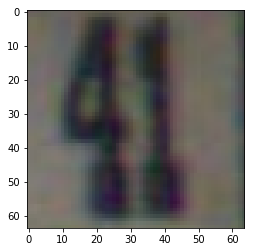

In [29]:
hide_code
image1 = scipy.ndimage.imread('train/30065.png')
print("Initial image size:", image1.shape)

n1 = np.where(train_filenames == '30065.png')[0]
label1 = train_labels[n1]

box1 = np.array(get_box(train_b['box'][n1]))
print("Digit boxes:\n", box1)
box_n1 = image_box(box1)
print("Digits' box: ", box_n1)

image_n1 = image1[box_n1[2]:box_n1[3], box_n1[0]:box_n1[1]]
image64_1 = scipy.misc.imresize(image_n1, (64, 64))/255
image64_2 = np.dot(np.array(image64_1, dtype='float32'), [0.299, 0.587, 0.114])

print("Final image size: ", image64_2.shape)
print("Final image label: ", label1)
print('\nExample of image preprocessing')

plt.imshow(image64_1, cmap=plt.cm.Blues);

Image size:  (32, 32)
Image label:  [[ 10.  10.  10.   2.   1.]]

Example of image preprocessing with the function


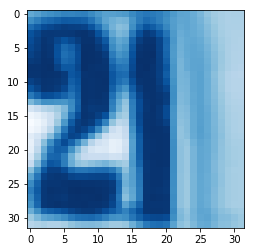

In [30]:
hide_code
image_example = get_image('train', '178.png')

print("Image size: ", image_example[1].shape)
print("Image label: ", image_example[2])
print('\nExample of image preprocessing with the function')
plt.imshow(image_example[1], cmap=plt.cm.Blues);

***Image preprocessing. Variant #1***

In [60]:
hide_code

print("Applying the preprocessing function")
# train_images1 = np.array([get_image('train', x)[0] for x in train_filenames[:13000])
# train_images2 = np.array([get_image('train', x)[1] for x in train_filenames[:13000]])

# test_images1 = np.array([get_image('test', x)[0] for x in test_filenames[:6000]])
# test_images2 = np.array([get_image('test', x)[1] for x in test_filenames[:6000]])

# extra_images1 = np.array([get_image('extra', x)[0] for x in extra_filenames[:13000]])
# extra_images2 = np.array([get_image('extra', x)[1] for x in extra_filenames[:13000]])

Applying the preprocessing function


***Image preprocessing. Variant #2***

#### Set #1: 13 000 train data points, 6 000 test data points, 13 000 extra data points

In [31]:
hide_code
train_images01 = np.array([get_image('train', x)[0] for x in train_filenames[:1000]])
train_images02 = np.array([get_image('train', x)[1] for x in train_filenames[:1000]]) 

i= 1000
print(i)

while i < 7001: 

        train_images11 = np.array([get_image('train', x)[0] for x in train_filenames[i:i+1000]])
        train_images12 = np.array([get_image('train', x)[1] for x in train_filenames[i:i+1000]]) 
        
        train_images1 = np.concatenate((train_images01, train_images11), axis=0)
        train_images2 = np.concatenate((train_images02, train_images12), axis=0)
        
        train_images01 = train_images1
        train_images02 = train_images2
        
        i += 1000
        print(i)

1000
2000
3000
4000
5000
6000
7000
8000


In [32]:
hide_code
train_images_8000_1 = train_images1
train_images_8000_2 = train_images2

len(train_images_8000_1)

8000

In [33]:
hide_code
train_images01 = np.array([get_image('train', x)[0] for x in train_filenames[8000:9000]])
train_images02 = np.array([get_image('train', x)[1] for x in train_filenames[8000:9000]]) 

i= 9000
print(i)

while i < 12001: 

        train_images11 = np.array([get_image('train', x)[0] for x in train_filenames[i:i+1000]])
        train_images12 = np.array([get_image('train', x)[1] for x in train_filenames[i:i+1000]]) 
        
        train_images1 = np.concatenate((train_images01, train_images11), axis=0)
        train_images2 = np.concatenate((train_images02, train_images12), axis=0)
        
        train_images01 = train_images1
        train_images02 = train_images2
        
        i += 1000
        print(i)

9000
10000
11000
12000
13000


In [35]:
hide_code
train_images_13000_1 = train_images1
train_images_13000_2 = train_images2

len(train_images_13000_1)

5000

In [36]:
hide_code
train_images1 = np.concatenate((train_images_8000_1, train_images_13000_1), axis=0)
train_images2 = np.concatenate((train_images_8000_2, train_images_13000_2), axis=0)

In [39]:
hide_code
train_images1t = train_images1.reshape(13000, 32*32*3)
train_images2t = train_images2.reshape(13000, 32*32)

train_images_df1 = pd.DataFrame(data=train_images1t, index = train_filenames[:13000])
train_images_df2 = pd.DataFrame(data=train_images2t, index = train_filenames[:13000])
train_labels_df = pd.DataFrame(data=train_labels[:13000], index = train_filenames[:13000])

with open('train_images1.csv', 'w') as f:
    train_images_df1.to_csv(f)
with open('train_images2.csv', 'w') as f:
    train_images_df2.to_csv(f)    
with open('train_labels.csv', 'w') as f:
    train_labels_df.to_csv(f)

In [40]:
hide_code
test_images01 = np.array([get_image('test', x)[0] for x in test_filenames[:1000]])
test_images02 = np.array([get_image('test', x)[1] for x in test_filenames[:1000]]) 

i= 1000
print(i)

while i < 5001:
    
    test_images11 = np.array([get_image('test', x)[0] for x in test_filenames[i:i+1000]])
    test_images12 = np.array([get_image('test', x)[1] for x in test_filenames[i:i+1000]]) 
        
    test_images1 = np.concatenate((test_images01, test_images11), axis=0)
    test_images2 = np.concatenate((test_images02, test_images12), axis=0)
        
    test_images01 = test_images1
    test_images02 = test_images2
        
    i += 1000
    print(i)

1000
2000
3000
4000
5000
6000


In [41]:
hide_code
test_images_6000_1 = test_images1
test_images_6000_2 = test_images2
len(test_images_6000_1)

6000

In [43]:
hide_code
test_images1t = test_images1.reshape(6000, 32*32*3)
test_images2t = test_images2.reshape(6000, 32*32)

test_images_df1 = pd.DataFrame(data=test_images1t, index = test_filenames[:6000])
test_images_df2 = pd.DataFrame(data=test_images2t, index = test_filenames[:6000])
test_labels_df = pd.DataFrame(data=test_labels[:6000], index = test_filenames[:6000])

with open('test_images1.csv', 'w') as f:
    test_images_df1.to_csv(f)
with open('test_images2.csv', 'w') as f:
    test_images_df2.to_csv(f)    
with open('test_labels.csv', 'w') as f:
    test_labels_df.to_csv(f)

In [44]:
hide_code
extra_images01 = np.array([get_image('extra', x)[0] for x in extra_filenames[:1000]])
extra_images02 = np.array([get_image('extra', x)[1] for x in extra_filenames[:1000]])

i= 1000
print(i)

while i < 7001:
    
    extra_images11 = np.array([get_image('extra', x)[0] for x in extra_filenames[i:i+1000]])
    extra_images12 = np.array([get_image('extra', x)[1] for x in extra_filenames[i:i+1000]]) 
        
    extra_images1 = np.concatenate((extra_images01, extra_images11), axis=0)
    extra_images2 = np.concatenate((extra_images02, extra_images12), axis=0)
        
    extra_images01 = extra_images1
    extra_images02 = extra_images2
        
    i += 1000
    print(i)

1000
2000
3000
4000
5000
6000
7000
8000


In [45]:
hide_code
extra_images_8000_1 = extra_images1
extra_images_8000_2 = extra_images2
len(extra_images_8000_1)

8000

In [46]:
hide_code
extra_images01 = np.array([get_image('extra', x)[0] for x in extra_filenames[8000:9000]])
extra_images02 = np.array([get_image('extra', x)[1] for x in extra_filenames[8000:9000]])

i = 9000
print(i)

while i < 12001:
    
    extra_images11 = np.array([get_image('extra', x)[0] for x in extra_filenames[i:i+1000]])
    extra_images12 = np.array([get_image('extra', x)[1] for x in extra_filenames[i:i+1000]]) 
        
    extra_images1 = np.concatenate((extra_images01, extra_images11), axis=0)
    extra_images2 = np.concatenate((extra_images02, extra_images12), axis=0)
        
    extra_images01 = extra_images1
    extra_images02 = extra_images2
        
    i += 1000
    print(i)

9000
10000
11000
12000
13000


In [47]:
hide_code
extra_images_13000_1 = extra_images1
extra_images_13000_2 = extra_images2
len(extra_images_13000_1)

5000

In [48]:
hide_code
extra_images1 = np.concatenate((extra_images_8000_1, extra_images_13000_1), axis=0)
extra_images2 = np.concatenate((extra_images_8000_2, extra_images_13000_2), axis=0)

In [50]:
hide_code
extra_images1t = extra_images1.reshape(13000, 32*32*3)
extra_images2t = extra_images2.reshape(13000, 32*32)

extra_images_df1 = pd.DataFrame(data=extra_images1t, index = extra_filenames[:13000])
extra_images_df2 = pd.DataFrame(data=extra_images2t, index = extra_filenames[:13000])
extra_labels_df = pd.DataFrame(data=extra_labels[:13000], index = extra_filenames[:13000])

with open('extra_images1.csv', 'w') as f:
    extra_images_df1.to_csv(f)
with open('extra_images2.csv', 'w') as f:
    extra_images_df2.to_csv(f)    
with open('extra_labels.csv', 'w') as f:
    extra_labels_df.to_csv(f)

In [51]:
hide_code
pickle_file = 'svhn1.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {'train_images1': train_images1, 'train_images2': train_images2,
            'train_labels': train_labels[:13000], 'train_filenames': train_filenames[:13000],
            'test_images1': test_images1, 'test_images2': test_images2,
            'test_labels': test_labels[:6000], 'test_filenames': test_filenames[:6000],
            'extra_images1': extra_images1, 'extra_images2': extra_images2,
            'extra_labels': extra_labels[:13000], 'extra_filenames': extra_filenames[:13000]}
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

del save
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1050431359


#### Set #2: 13 000 train data points, 6 000 test data points, 13 000 extra data points

In [54]:
hide_code
train_images01 = np.array([get_image('train', x)[0] for x in train_filenames[13000:14000]])
train_images02 = np.array([get_image('train', x)[1] for x in train_filenames[13000:14000]]) 

i= 14000
print(i)

while i < 18001: 
    
        train_images11 = np.array([get_image('train', x)[0] for x in train_filenames[i:i+1000]])
        train_images12 = np.array([get_image('train', x)[1] for x in train_filenames[i:i+1000]]) 
        
        train_images1 = np.concatenate((train_images01, train_images11), axis=0)
        train_images2 = np.concatenate((train_images02, train_images12), axis=0)
        
        train_images01 = train_images1
        train_images02 = train_images2
        
        i += 1000
        print(i)

14000
15000
16000
17000
18000
19000


In [55]:
hide_code
train_images_19000_1 = train_images1
train_images_19000_2 = train_images2
len(train_images_19000_1)

6000

In [56]:
hide_code
train_images01 = np.array([get_image('train', x)[0] for x in train_filenames[19000:20000]])
train_images02 = np.array([get_image('train', x)[1] for x in train_filenames[19000:20000]]) 

i= 20000
print(i)

while i < 25001: 
    
        train_images11 = np.array([get_image('train', x)[0] for x in train_filenames[i:i+1000]])
        train_images12 = np.array([get_image('train', x)[1] for x in train_filenames[i:i+1000]]) 
        
        train_images1 = np.concatenate((train_images01, train_images11), axis=0)
        train_images2 = np.concatenate((train_images02, train_images12), axis=0)
        
        train_images01 = train_images1
        train_images02 = train_images2
        
        i += 1000
        print(i)

20000
21000
22000
23000
24000
25000
26000


In [57]:
hide_code
train_images_26000_1 = train_images1
train_images_26000_2 = train_images2
len(train_images_26000_1)

7000

In [58]:
hide_code
train_images1 = np.concatenate((train_images_19000_1, train_images_26000_1), axis=0)
train_images2 = np.concatenate((train_images_19000_2, train_images_26000_2), axis=0)

In [61]:
hide_code
train_images1t = train_images1.reshape(13000, 32*32*3)
train_images2t = train_images2.reshape(13000, 32*32)

train_images_df1 = pd.DataFrame(data=train_images1t, index = train_filenames[13000:26000])
train_images_df2 = pd.DataFrame(data=train_images2t, index = train_filenames[13000:26000])
train_labels_df = pd.DataFrame(data=train_labels[13000:26000], index = train_filenames[13000:26000])

with open('train_images1_2.csv', 'w') as f:
    train_images_df1.to_csv(f)
with open('train_images2_2.csv', 'w') as f:
    train_images_df2.to_csv(f)    
with open('train_labels_2.csv', 'w') as f:
    train_labels_df.to_csv(f)

In [62]:
hide_code
test_images01 = np.array([get_image('test', x)[0] for x in test_filenames[7000:8000]])
test_images02 = np.array([get_image('test', x)[1] for x in test_filenames[7000:8000]])

i= 8000
print(i)

while i < 12001:
    
    test_images11 = np.array([get_image('test', x)[0] for x in test_filenames[i:i+1000]])
    test_images12 = np.array([get_image('test', x)[1] for x in test_filenames[i:i+1000]]) 
        
    test_images1 = np.concatenate((test_images01, test_images11), axis=0)
    test_images2 = np.concatenate((test_images02, test_images12), axis=0)
        
    test_images01 = test_images1
    test_images02 = test_images2
        
    i += 1000
    print(i)

8000
9000
10000
11000
12000
13000


In [63]:
hide_code
test_images_13000_1 = test_images1
test_images_13000_2 = test_images2
len(test_images_13000_1)

6000

In [66]:
hide_code
test_images1t = test_images1.reshape(6000, 32*32*3)
test_images2t = test_images2.reshape(6000, 32*32)

test_images_df1 = pd.DataFrame(data=test_images1t, index = test_filenames[7000:13000])
test_images_df2 = pd.DataFrame(data=test_images2t, index = test_filenames[7000:13000])
test_labels_df = pd.DataFrame(data=test_labels[7000:13000], index = test_filenames[7000:13000])

with open('test_images1_2.csv', 'w') as f:
    test_images_df1.to_csv(f)
with open('test_images2_2.csv', 'w') as f:
    test_images_df2.to_csv(f)    
with open('test_labels_2.csv', 'w') as f:
    test_labels_df.to_csv(f)

In [67]:
hide_code
extra_images01 = np.array([get_image('extra', x)[0] for x in extra_filenames[13000:14000]])
extra_images02 = np.array([get_image('extra', x)[1] for x in extra_filenames[13000:14000]])

i= 14000
print(i)

while i < 18001:
    
    extra_images11 = np.array([get_image('extra', x)[0] for x in extra_filenames[i:i+1000]])
    extra_images12 = np.array([get_image('extra', x)[1] for x in extra_filenames[i:i+1000]]) 
        
    extra_images1 = np.concatenate((extra_images01, extra_images11), axis=0)
    extra_images2 = np.concatenate((extra_images02, extra_images12), axis=0)
        
    extra_images01 = extra_images1
    extra_images02 = extra_images2
        
    i += 1000
    print(i)

14000
15000
16000
17000
18000
19000


In [68]:
hide_code
extra_images_19000_1 = extra_images1
extra_images_19000_2 = extra_images2
len(extra_images_19000_1)

6000

In [78]:
hide_code
extra_images01 = np.array([get_image('extra', x)[0] for x in extra_filenames[25000:26000]])
extra_images02 = np.array([get_image('extra', x)[1] for x in extra_filenames[25000:26000]])

i= 26000
print(i)

while i < 31001:
    
    extra_images11 = np.array([get_image('extra', x)[0] for x in extra_filenames[i:i+1000]])
    extra_images12 = np.array([get_image('extra', x)[1] for x in extra_filenames[i:i+1000]]) 
        
    extra_images1 = np.concatenate((extra_images01, extra_images11), axis=0)
    extra_images2 = np.concatenate((extra_images02, extra_images12), axis=0)
        
    extra_images01 = extra_images1
    extra_images02 = extra_images2
        
    i += 1000
    print(i)

26000
27000
28000
29000
30000
31000
32000


In [79]:
hide_code
extra_images_32000_1 = extra_images1
extra_images_32000_2 = extra_images2
len(extra_images_32000_1)

7000

In [80]:
hide_code
extra_images1 = np.concatenate((extra_images_19000_1, extra_images_32000_1), axis=0)
extra_images2 = np.concatenate((extra_images_19000_2, extra_images_32000_2), axis=0)
extra_filenames2 = np.concatenate((extra_filenames[13000:19000], extra_filenames[25000:32000]), axis=0)
extra_labels2 = np.concatenate((extra_labels[13000:19000], extra_labels[25000:32000]), axis=0)

In [82]:
hide_code
extra_images1t = extra_images1.reshape(13000, 32*32*3)
extra_images2t = extra_images2.reshape(13000, 32*32)

extra_images_df1 = pd.DataFrame(data=extra_images1t, index = extra_filenames2)
extra_images_df2 = pd.DataFrame(data=extra_images2t, index = extra_filenames2)
extra_labels_df = pd.DataFrame(data=extra_labels2, index = extra_filenames2)

with open('extra_images1_2.csv', 'w') as f:
    extra_images_df1.to_csv(f)
with open('extra_images2_2.csv', 'w') as f:
    extra_images_df2.to_csv(f)    
with open('extra_labels_2.csv', 'w') as f:
    extra_labels_df.to_csv(f)

In [83]:
hide_code
pickle_file = 'svhn2.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {'train_images1': train_images1, 'train_images2': train_images2,
            'train_labels': train_labels[13000:26000], 'train_filenames': train_filenames[13000:26000],
            'test_images1': test_images1, 'test_images2': test_images2,
            'test_labels': test_labels[7000:13000], 'test_filenames': test_filenames[7000:13000],
            'extra_images1': extra_images1, 'extra_images2': extra_images2,
            'extra_labels': extra_labels2, 'extra_filenames': extra_filenames2}
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

del save
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1050440267


#### Checkpoint 2. Load the realistic data and prepare features and targets

In [15]:
hide_code
train_images2 = pd.read_csv("train_images2.csv")
train_labels = pd.read_csv("train_labels.csv")

test_images2 = pd.read_csv("test_images2.csv")
test_labels = pd.read_csv("test_labels.csv")

extra_images2 = pd.read_csv("extra_images2.csv")
extra_labels = pd.read_csv("extra_labels.csv")

display(train_images2[["0", "1", "2", "3", "4", "5"]].head(3))
display(train_labels.head(3))

display(test_images2[["0", "1", "2", "3", "4", "5"]].head(3))
display(test_labels.tail(3))

display(extra_images2[["0", "1", "2", "3", "4", "5"]].head(3))
display(extra_labels.tail(3))

,0,1,2,3,4,5
0,0.352349,0.366906,0.373620,0.360278,0.330929,0.309424
1,0.754941,0.726082,0.680365,0.628380,0.572475,0.520447
2,0.180714,0.192925,0.204243,0.226600,0.233271,0.227729


,filename,0,1,2,3,4
0,5502.png,10.0,10.0,10.0,3.0,5.0
1,6876.png,10.0,10.0,10.0,1.0,5.0
2,12741.png,10.0,10.0,10.0,2.0,9.0


,0,1,2,3,4,5
0,0.731729,0.731729,0.731729,0.732859,0.732859,0.732859
1,0.605008,0.630882,0.635082,0.611831,0.572169,0.529757
2,0.194851,0.167078,0.128478,0.133976,0.132525,0.134549


,filename,0,1,2,3,4
5997,10065.png,10.0,10.0,10.0,10.0,1.0
5998,10210.png,10.0,10.0,10.0,1.0,9.0
5999,11166.png,10.0,10.0,10.0,5.0,0.0


,0,1,2,3,4,5
0,0.857800,0.857800,0.853878,0.843733,0.848102,0.845800
1,0.300451,0.338773,0.371553,0.384278,0.404569,0.421384
2,0.263635,0.266596,0.236608,0.205769,0.195455,0.208671


,filename,0,1,2,3,4
12997,11978.png,10.0,10.0,8.0,5.0,7.0
12998,13237.png,10.0,10.0,10.0,9.0,0.0
12999,11985.png,10.0,10.0,10.0,5.0,6.0


In [16]:
hide_code
train_images2_2 = pd.read_csv("train_images2_2.csv")
train_labels_2 = pd.read_csv("train_labels_2.csv")

test_images2_2 = pd.read_csv("test_images2_2.csv")
test_labels_2 = pd.read_csv("test_labels_2.csv")

extra_images2_2 = pd.read_csv("extra_images2_2.csv")
extra_labels_2 = pd.read_csv("extra_labels_2.csv")

display(train_images2_2[["0", "1", "2", "3", "4", "5"]].head(3))
display(train_labels_2.head(3))

display(test_images2_2[["0", "1", "2", "3", "4", "5"]].head(3))
display(test_labels_2.tail(3))

display(extra_images2_2[["0", "1", "2", "3", "4", "5"]].head(3))
display(extra_labels_2.tail(3))

,0,1,2,3,4,5
0,0.775827,0.747204,0.702894,0.695498,0.694773,0.713933
1,0.924996,0.893624,0.846353,0.800020,0.749486,0.703769
2,0.595980,0.603780,0.615224,0.632933,0.653882,0.679435


,filename,0,1,2,3,4
0,20953.png,10.0,10.0,1.0,9.0,5.0
1,30030.png,10.0,10.0,10.0,3.0,4.0
2,2036.png,10.0,10.0,10.0,8.0,2.0


,0,1,2,3,4,5
0,0.160784,0.163533,0.165835,0.160784,0.161914,0.161914
1,0.642588,0.638388,0.637427,0.638769,0.628067,0.590192
2,0.059059,0.066220,0.077302,0.085145,0.094396,0.078710


,filename,0,1,2,3,4
5997,9152.png,10.0,10.0,1.0,2.0,6.0
5998,2724.png,10.0,10.0,10.0,4.0,8.0
5999,7566.png,10.0,10.0,10.0,1.0,4.0


,0,1,2,3,4,5
0,0.349059,0.394220,0.455067,0.517937,0.553188,0.557110
1,0.199129,0.195208,0.192416,0.182271,0.183890,0.169612
2,0.220420,0.220420,0.219694,0.218243,0.223059,0.225529


,filename,0,1,2,3,4
12997,31666.png,10.0,10.0,1.0,5.0,7.0
12998,32070.png,10.0,10.0,10.0,3.0,8.0
12999,31858.png,10.0,10.0,2.0,1.0,2.0


In [17]:
hide_code
images = np.concatenate((np.array(train_images2.drop('filename', axis=1)), 
                         np.array(extra_images2.drop('filename', axis=1))), 
                        axis=0)
labels = np.concatenate((np.array(train_labels[["0", "1", "2", "3", "4"]]), 
                         np.array(extra_labels[["0", "1", "2", "3", "4"]])), 
                        axis=0)

In [18]:
hide_code
images_2 = np.concatenate((np.array(train_images2_2.drop('filename', axis=1)), 
                           np.array(extra_images2_2.drop('filename', axis=1))), 
                          axis=0)
labels_2 = np.concatenate((np.array(train_labels_2[["0", "1", "2", "3", "4"]]), 
                           np.array(extra_labels_2[["0", "1", "2", "3", "4"]])), 
                          axis=0)

In [19]:
hide_code
images = np.concatenate((images, images_2), axis=0)
labels = np.concatenate((labels, labels_2), axis=0)

In [20]:
hide_code
images_t = np.concatenate((np.array(test_images2.drop('filename', axis=1)), 
                           np.array(test_images2_2.drop('filename', axis=1))), 
                          axis=0)
labels_t = np.concatenate((np.array(test_labels[["0", "1", "2", "3", "4"]]), 
                           np.array(test_labels_2[["0", "1", "2", "3", "4"]])), 
                          axis=0)

In [21]:
hide_code
X_train = images.reshape(52000, 32, 32, 1)
y_train = labels
X_test = images_t.reshape(12000, 32, 32, 1)
y_test = labels_t

In [22]:
hide_code
def digit_to_categorical(data):
    n = data.shape[1]
    data_cat = np.empty([len(data), n, 11])
    
    for i in range(n):
        data_cat[:, i] = ks.utils.to_categorical(data[:, i], num_classes=11)
        
    return data_cat

y_train_cat = digit_to_categorical(y_train)
y_test_cat = digit_to_categorical(y_test)

y_train_cat_list = [y_train_cat[:, i] for i in range(5)]
y_test_cat_list = [y_test_cat[:, i] for i in range(5)]

In [23]:
hide_code
print('Train loaded set', X_train.shape, y_train_cat.shape)
print('Test loaded set', X_test.shape, y_test_cat.shape)

Train loaded set (52000, 32, 32, 1) (52000, 5, 11)
Test loaded set (12000, 32, 32, 1) (12000, 5, 11)


8629.png
[ 10.  10.   5.   0.   7.]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]


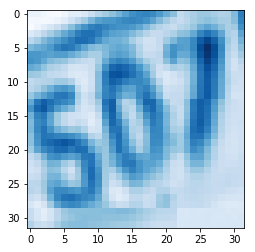

In [24]:
hide_code
plt.imshow(X_train[12].reshape(32, 32), cmap=plt.cm.Blues)
print(train_images2['filename'][12])
print(y_train[12])
print(y_train_cat[:][12])

---
## $\mathfrak {\color{#191970} {Step \ 2:\ Train \ a \ Model \ on \ a \ Realistic \ Dataset}}$
Once we have settled on a good architecture, we can train the model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

In [25]:
hide_code
def cnn_model():    
    model_input = Input(shape=(32, 32, 1))    
        
    x = Conv2D(32, (3, 3), activation='relu', border_mode='same')(model_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x)       
    x = Conv2D(64, (3, 3), activation='relu')(x)
    
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), activation='relu')(x)
    
    x = Dropout(0.25)(x)
              
    x = Flatten()(x)
    
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    y1 = Dense(11, activation='softmax')(x)
    y2 = Dense(11, activation='softmax')(x)
    y3 = Dense(11, activation='softmax')(x)
    y4 = Dense(11, activation='softmax')(x)
    y5 = Dense(11, activation='softmax')(x)
    
    model = Model(input=model_input, output=[y1, y2, y3, y4, y5])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [26]:
hide_code
cnn_model = cnn_model()

history1 = cnn_model.fit(X_train, y_train_cat_list, validation_data=(X_test, y_test_cat_list), 
                         epochs=50, batch_size=128, verbose=2)

Train on 52000 samples, validate on 12000 samples
Epoch 1/50
124s - loss: 6.3544 - dense_2_loss: 0.0414 - dense_3_loss: 0.3000 - dense_4_loss: 1.4141 - dense_5_loss: 2.2722 - dense_6_loss: 2.3267 - dense_2_acc: 0.9971 - dense_3_acc: 0.9402 - dense_4_acc: 0.5650 - dense_5_acc: 0.1729 - dense_6_acc: 0.1216 - val_loss: 4.6298 - val_dense_2_loss: 0.0015 - val_dense_3_loss: 0.0474 - val_dense_4_loss: 0.4785 - val_dense_5_loss: 1.8496 - val_dense_6_loss: 2.2529 - val_dense_2_acc: 0.9998 - val_dense_3_acc: 0.9885 - val_dense_4_acc: 0.8562 - val_dense_5_acc: 0.3618 - val_dense_6_acc: 0.1647
Epoch 2/50
110s - loss: 4.9020 - dense_2_loss: 0.0043 - dense_3_loss: 0.2038 - dense_4_loss: 0.9423 - dense_5_loss: 1.6818 - dense_6_loss: 2.0699 - dense_2_acc: 0.9996 - dense_3_acc: 0.9445 - dense_4_acc: 0.7020 - dense_5_acc: 0.4159 - dense_6_acc: 0.2387 - val_loss: 3.1799 - val_dense_2_loss: 0.0020 - val_dense_3_loss: 0.0478 - val_dense_4_loss: 0.3254 - val_dense_5_loss: 1.1307 - val_dense_6_loss: 1.6741 

In [27]:
hide_code
cnn_scores = cnn_model.evaluate(X_test, y_test_cat_list, verbose=0)

print("CNN Model 1. Scores: \n" , (cnn_scores))
print("CNN Model 1. First digit. CNN Accuracy: %.2f%%" % (cnn_scores[6]*100))
print("CNN Model 1. Second digit. CNN Accuracy: %.2f%%" % (cnn_scores[7]*100))
print("CNN Model 1. Third digit. CNN Accuracy: %.2f%%" % (cnn_scores[8]*100))
print("CNN Model 1. Fourth digit. CNN Accuracy: %.2f%%" % (cnn_scores[9]*100))
print("CNN Model 1. Fifth digit. CNN Accuracy: %.2f%%" % (cnn_scores[10]*100))

print(cnn_model.summary())

CNN Model 1. Scores: 
 [0.77204345868031188, 0.0011618133640643388, 0.016621892407115715, 0.12785550048202277, 0.28263009973367054, 0.34377415227890012, 0.99983333333333335, 0.99516666666666664, 0.96525000000000005, 0.92283333333333328, 0.89733333333333332]
CNN Model 1. First digit. CNN Accuracy: 99.98%
CNN Model 1. Second digit. CNN Accuracy: 99.52%
CNN Model 1. Third digit. CNN Accuracy: 96.53%
CNN Model 1. Fourth digit. CNN Accuracy: 92.28%
CNN Model 1. Fifth digit. CNN Accuracy: 89.73%
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 32, 32)    320         input_1[0][0]                    


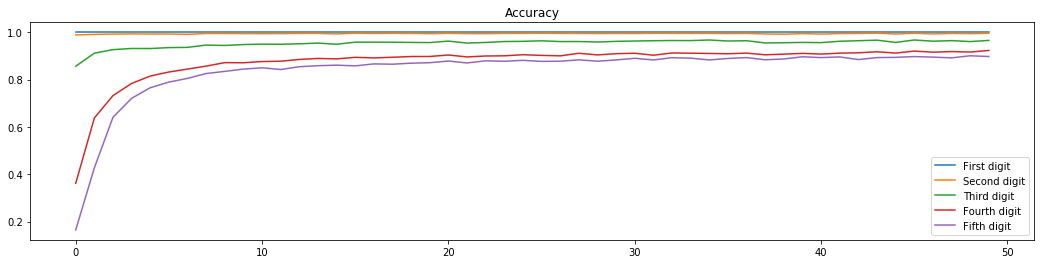

In [28]:
hide_code
plt.figure(figsize=(18, 4))

plt.plot(history1.history['val_dense_2_acc'], label = 'First digit')
plt.plot(history1.history['val_dense_3_acc'], label = 'Second digit')
plt.plot(history1.history['val_dense_4_acc'], label = 'Third digit')
plt.plot(history1.history['val_dense_5_acc'], label = 'Fourth digit')
plt.plot(history1.history['val_dense_6_acc'], label = 'Fifth digit')

plt.legend()
plt.title('Accuracy');

In [29]:
hide_code
avg_accuracy = sum([cnn_scores[i] for i in range(6, 11)])/5

print("CNN Model 1. Average Accuracy: %.2f%%" % (avg_accuracy*100))

CNN Model 1. Average Accuracy: 95.61%


In [34]:
hide_code
def cnn_model2():    
    model_input = Input(shape=(32, 32, 1))  
    
    x = BatchNormalization()(model_input)
        
    x = Conv2D(32, (5, 5), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, (5, 5), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Dropout(0.25)(x)
              
    x = Flatten()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    y1 = Dense(11, activation='softmax')(x)
    y2 = Dense(11, activation='softmax')(x)
    y3 = Dense(11, activation='softmax')(x)
    y4 = Dense(11, activation='softmax')(x)
    y5 = Dense(11, activation='softmax')(x)
    
    model = Model(input=model_input, output=[y1, y2, y3, y4, y5])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [35]:
hide_code
cnn_model2 = cnn_model2()

history2 = cnn_model2.fit(X_train, y_train_cat_list, validation_data=(X_test, y_test_cat_list), 
                          epochs=75, batch_size=128, verbose=2)

Train on 52000 samples, validate on 12000 samples
Epoch 1/75
154s - loss: 4.8541 - dense_14_loss: 0.0313 - dense_15_loss: 0.2388 - dense_16_loss: 1.0507 - dense_17_loss: 1.7147 - dense_18_loss: 1.8185 - dense_14_acc: 0.9973 - dense_15_acc: 0.9421 - dense_16_acc: 0.6795 - dense_17_acc: 0.4175 - dense_18_acc: 0.3633 - val_loss: 2.4020 - val_dense_14_loss: 0.0024 - val_dense_15_loss: 0.0399 - val_dense_16_loss: 0.2985 - val_dense_17_loss: 0.9222 - val_dense_18_loss: 1.1390 - val_dense_14_acc: 0.9998 - val_dense_15_acc: 0.9907 - val_dense_16_acc: 0.9238 - val_dense_17_acc: 0.7421 - val_dense_18_acc: 0.6617
Epoch 2/75
149s - loss: 2.9997 - dense_14_loss: 0.0045 - dense_15_loss: 0.1497 - dense_16_loss: 0.6885 - dense_17_loss: 1.0196 - dense_18_loss: 1.1373 - dense_14_acc: 0.9996 - dense_15_acc: 0.9554 - dense_16_acc: 0.7855 - dense_17_acc: 0.6656 - dense_18_acc: 0.6192 - val_loss: 1.7951 - val_dense_14_loss: 0.0026 - val_dense_15_loss: 0.0337 - val_dense_16_loss: 0.2306 - val_dense_17_loss: 

In [36]:
hide_code
cnn_scores2 = cnn_model2.evaluate(X_test, y_test_cat_list, verbose=0)

print("CNN Model 2. Scores: \n" , (cnn_scores2))
print("CNN Model 2. First digit. Accuracy: %.2f%%" % (cnn_scores2[6]*100))
print("CNN Model 2. Second digit. Accuracy: %.2f%%" % (cnn_scores2[7]*100))
print("CNN Model 2. Third digit. Accuracy: %.2f%%" % (cnn_scores2[8]*100))
print("CNN Model 2. Fourth digit. Accuracy: %.2f%%" % (cnn_scores2[9]*100))
print("CNN Model 2. Fifth digit. Accuracy: %.2f%%" % (cnn_scores2[10]*100))

print(cnn_model2.summary())

CNN Model 2. Scores: 
 [0.85547728419303892, 0.0019149356962359435, 0.01576452326722938, 0.12598609016587337, 0.31996486308177313, 0.39184686940908431, 0.99983333333333335, 0.996, 0.96566666666666667, 0.91241666666666665, 0.88266666666666671]
CNN Model 2. First digit. Accuracy: 99.98%
CNN Model 2. Second digit. Accuracy: 99.60%
CNN Model 2. Third digit. Accuracy: 96.57%
CNN Model 2. Fourth digit. Accuracy: 91.24%
CNN Model 2. Fifth digit. Accuracy: 88.27%
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
batch_normalization_2 (BatchNorm (None, 32, 32, 1)     4           input_3[0][0]                    
___________________________________

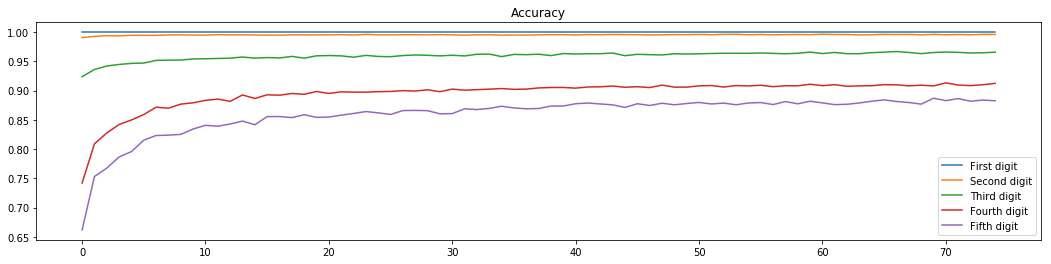

In [37]:
hide_code
plt.figure(figsize=(18, 4))

plt.plot(history2.history['val_dense_14_acc'], label = 'First digit')
plt.plot(history2.history['val_dense_15_acc'], label = 'Second digit')
plt.plot(history2.history['val_dense_16_acc'], label = 'Third digit')
plt.plot(history2.history['val_dense_17_acc'], label = 'Fourth digit')
plt.plot(history2.history['val_dense_18_acc'], label = 'Fifth digit')

plt.legend()
plt.title('Accuracy');

In [38]:
hide_code
avg_accuracy2 = sum([cnn_scores2[i] for i in range(6, 11)])/5

print("CNN Model 2. Average Accuracy: %.2f%%" % (avg_accuracy2*100))

CNN Model 2. Average Accuracy: 95.13%


***Save the Models***

In [39]:
cnn_model.save('cnn_model_file1_1.h5')

In [40]:
cnn_model2.save('cnn_model2_file1_1.h5')

---
## $\mathfrak {\color{#191970} {Questions \ and \ Answers}}$

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_
### Answer 4
Tens of thousands of photos were processed as follows:

- fields of photos that do not contain digits were cut off;
- the photos were formatted to the standard 32X32 size and three color channels were converted into one channel (gray scale);
- each of the resulting images was represented as an array of numbers;
- two sets of data (training and test data) were made from these arrays; 
- the data were recorded in files of two different formats for the convenience of repeated use.

I have found two ways to impove the model for the best results on a realistic dataset:

- the first model shows the average accuracy 95.61%;
- the second model shows the average accuracy 95.13%.

---
### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_
### Answer 5
The architecture of the model were changed.

- In the first case:
   - the layer *Conv2D(128, (3, 3), activation='relu')* was added;
   - *Dropout(0.25)*, *Dropout(0.25)*, *Dropout(0.25)*, *Dropout(0.5)* layers were used instead of *Dropout(0.2)*, *Dropout(0.2)*, *Dropout(0.4)*.
   
- In the second case, there is a big difference between the initial model and the starter one:
  - two convolutional layers *Conv2D(32, (5, 5), activation='relu')* and *Conv2D(64, (5, 5), activation='relu')* instead of four *Conv2D(32, (3, 3), activation='relu')*, *Conv2D(32, (3, 3), activation='relu')*, *Conv2D(64, (3, 3), activation='relu')*, *Conv2D(64, (3, 3), activation='relu')*; 
  - the *BatchNormalization()* layer was added;
  - the first *Dense* layer has dimensionality [256] instead of [512];
  - *Dropout(0.25)*, *Dropout(0.25)*, *Dropout(0.5)* layers instead of *Dropout(0.2)*, *Dropout(0.2)*, *Dropout(0.4)*.

The number of the epochs became greater (50 and 75 instead of 20).

In both cases the result became worse with reducing the batch size (for example, 128 -> 64).

---
### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_
### Answer 6
The initial values of accuracy were in 79-86%. The final level about 95% is an advanced result for the real data.
So the model can do a good job at classifying numbers. Of course, the result can be improved by further research to achieve even higher accuracy.